In [90]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')

from esio import EsioData as ed
from esio import metrics
from esio import ice_plot

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
#############################################################
# Load in Data
#############################################################
E = ed.EsioData.load()
# Get data
product_list = ['NSIDC_0081', 'NSIDC_0051', 'NSIDC_0079']

c_product = product_list[0]

print(E.obs[c_product]['sipn_nc']+'_yearly/'+str(cyear)+'.nc')
ds_81 = xr.open_mfdataset(E.obs[c_product]['sipn_nc']+'_yearly/*.nc', concat_dim='time')



/home/disk/sipn/nicway/data/obs/NSIDC_0081/sipn_nc_yearly/2017.nc


In [92]:
print(ds_81)

<xarray.Dataset>
Dimensions:    (time: 1557, x: 304, y: 448)
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    hole_mask  (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm         (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym         (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-04-06
Data variables:
    sic        (time, y, x) float64 dask.array<shape=(1557, 448, 304), chunksize=(365, 448, 304)>
    extent     (time) float64 dask.array<shape=(1557,), chunksize=(365,)>
    area       (time) float64 dask.array<shape=(1557,), chunksize=(365,)>


In [ ]:
# Calc observed Ice Free Day
da_IFD = ds_81.sic.groupby('time.year').apply(metrics.calc_IFD)
da_IFD.name = 'IFD'

In [151]:
cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Purples", 20))
cmap_c.set_bad(color = 'lightgrey')

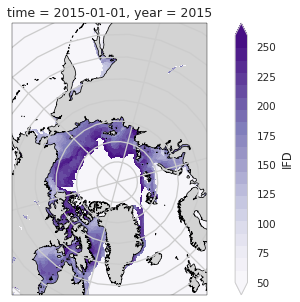

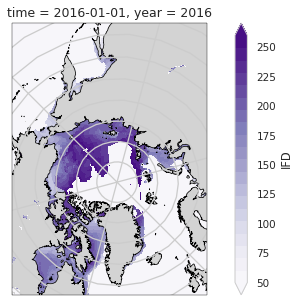

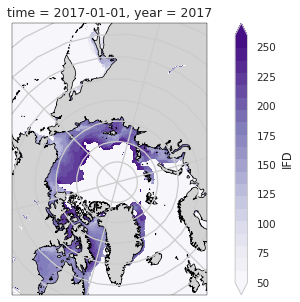

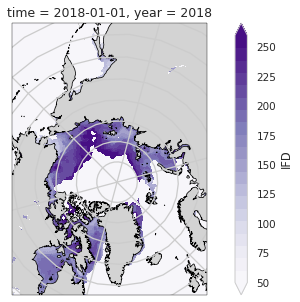

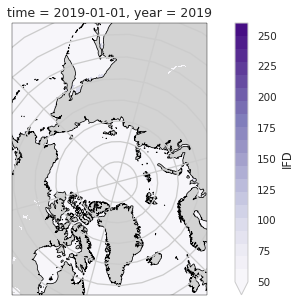

In [156]:
for y in da_IFD.year:
    (f, ax1) = ice_plot.polar_axis()
    f.set_size_inches(10, 5)
    p = da_IFD.sel(year=y).plot(ax=ax1,  x='lon', y='lat', 
                 cmap=cmap_c, vmin=50, vmax=260,
                  transform=ccrs.PlateCarree());
    # Save to file
dir_out = os.path.join(E.obs_dir, c_product, 'agg_nc')

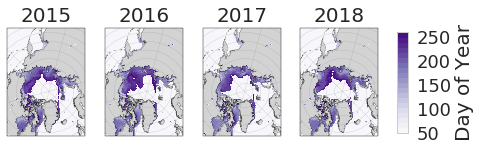

In [155]:
(f, axes) = ice_plot.multi_polar_axis(ncols=5, nrows=1, Nplots=5, sizefcter=1)
c_vmin=50
c_vmax=260
p = {}
c_label='Day of Year'
for y in np.arange(2015,2019,1):
    ax_num=y-2015
    p[ax_num]=da_IFD.sel(year=y).plot.pcolormesh(ax=axes[ax_num], x='lon', y='lat', 
                                              transform=ccrs.PlateCarree(),
                                              add_colorbar=False,
                                              cmap=cmap_c,
                                              vmin=c_vmin, vmax=c_vmax)
    axes[ax_num].set_title(str(y), fontsize=20)
    
# Make pretty
f.subplots_adjust(right=1)
cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
if p: # if its not empty
    cbar = f.colorbar(next(iter(p.values())), cax=cbar_ax, label=c_label) # use first plot to gen colorbar
    cbar.set_ticks(np.arange(50,300,50))
    cbar.ax.tick_params(labelsize=18) 
    cbar.set_label(label=c_label,fontsize=20)

f_out = os.path.join(dir_out,c_product+'_IFD.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
#print("saved ", f_out)

In [102]:
dir_out = os.path.join(E.obs_dir, c_product, 'agg_nc')
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
print(dir_out)

/home/disk/sipn/nicway/data/obs/NSIDC_0081/agg_nc


In [74]:
da_IFD.to_netcdf(os.path.join(dir_out, 'IFD_FFD.nc'))

In [75]:
da_IFD = None